In [635]:
import ncempy.io as nio
dmData = nio.read('C:\\Promo\\TEM\\NRC\\Lucas\\DP_of_Si_at_[011]_CL0_25mI1_3.13.dm3')
print(dmData['data'].shape) # the shape of the data
print(dmData['pixelSize']) # print the pixel size

(2004, 1336)
[1.0, 1.0]


In [636]:

tem_img=dmData['data']

## Load the image, to see what it looks like ##


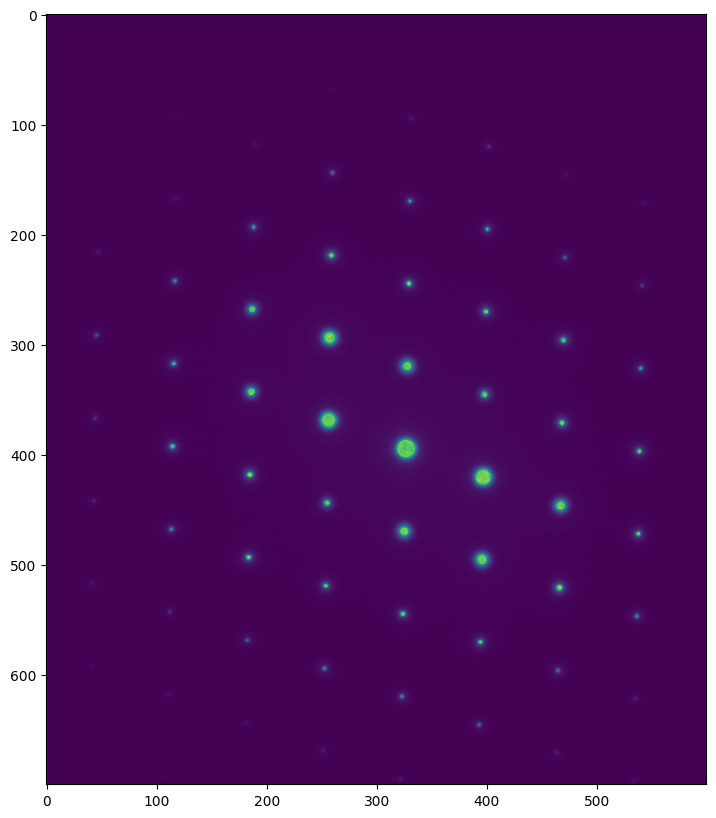

In [637]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(10,10))
plt.imshow(tem_img,cmap='gray')
img_new=tem_img[500:1200,300:900]
plt.imshow(img_new)

## playing around with 1d peak detection ##


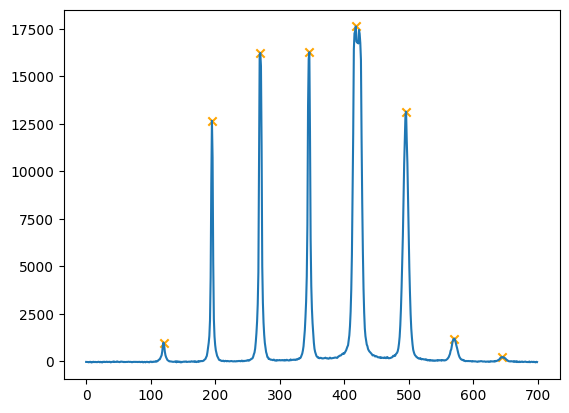

In [638]:
import scipy.signal as signal
import numpy as np
plt.plot(img_new[:,400])
[peaks,peak_info]=signal.find_peaks(img_new[:,400],distance=30,prominence=0.01*np.max(img_new))
plt.scatter(peaks,img_new[peaks,400],marker="x",color='orange')

In [639]:
from numpy import matlib
matlib.repmat(1,1,peaks.size)

array([[1, 1, 1, 1, 1, 1, 1, 1]])

In [640]:

from skimage.feature import peak_local_max

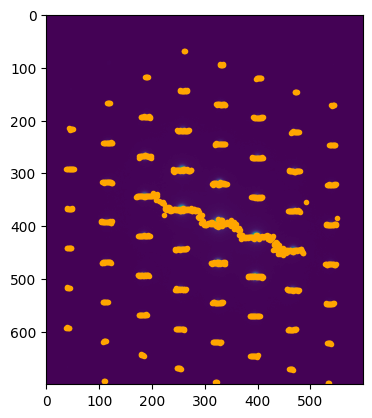

In [641]:
# import scipy.signal as signal
# import numpy as np
plt.imshow(img_new)
for i in range(img_new.shape[1]):
    [peaks,peak_info]=signal.find_peaks(img_new[:,i],distance=30,prominence=0.01*np.max(img_new))
    plt.scatter(matlib.repmat(i,1,peaks.size),peaks,marker=".",color='orange')

## playing around with 2d peak detection ## 

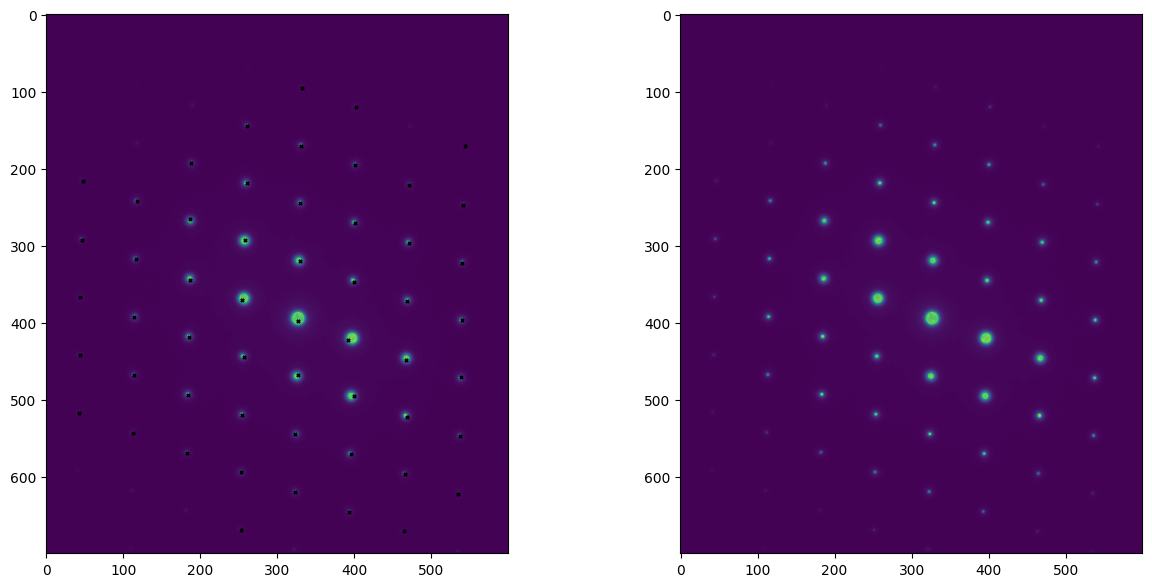

In [642]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
coordinates = peak_local_max(img_new, min_distance=10,threshold_abs=0.05*np.max(img_new))
ax[0].imshow(img_new)
ax[0].scatter(coordinates[:,1],coordinates[:,0],marker='x',s=5,color='black')
ax[1].imshow(img_new)

In [611]:
coordinates.shape

(114, 2)

In [612]:
diffs=[]
for i in range(coordinates.shape[0]):
    for j in range(coordinates.shape[0]):
        dist=np.sqrt((coordinates[j,0]-coordinates[i,0])**2+(coordinates[j,0]-coordinates[i,0])**2)
        diffs.append(dist)


In [613]:
diffs=np.array(diffs)

## use these as inut for a 2d gauss fit, to get the positioon of the diffractions highly accure ##
https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html


In [643]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian

In [644]:
npoints = 10000
np.random.seed(2021)
x = np.random.rand(npoints)*10 - 4
y = np.random.rand(npoints)*5 - 3
z = gaussian2d(x, y, amplitude=30, centerx=2, centery=-.5, sigmax=.6, sigmay=.8)
z += 2*(np.random.rand(*z.shape)-.5)
error = np.sqrt(z+1)    

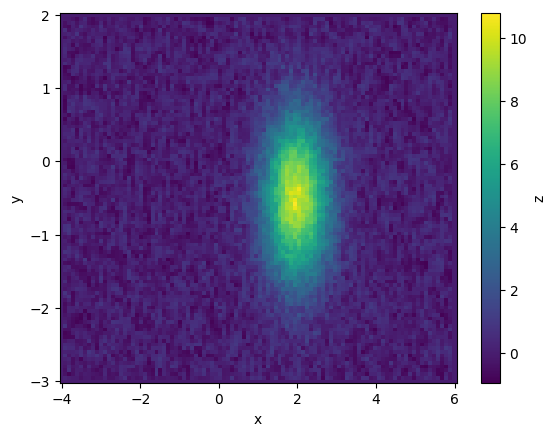

In [645]:
X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100),
                   np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear', fill_value=0)

fig, ax = plt.subplots()
art = ax.pcolor(X, Y, Z, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [646]:
model = lmfit.models.Gaussian2dModel()
params = model.guess(z, x, y)
result = model.fit(z, x=x, y=y, params=params, weights=1/error)
# lmfit.report_fit(result)

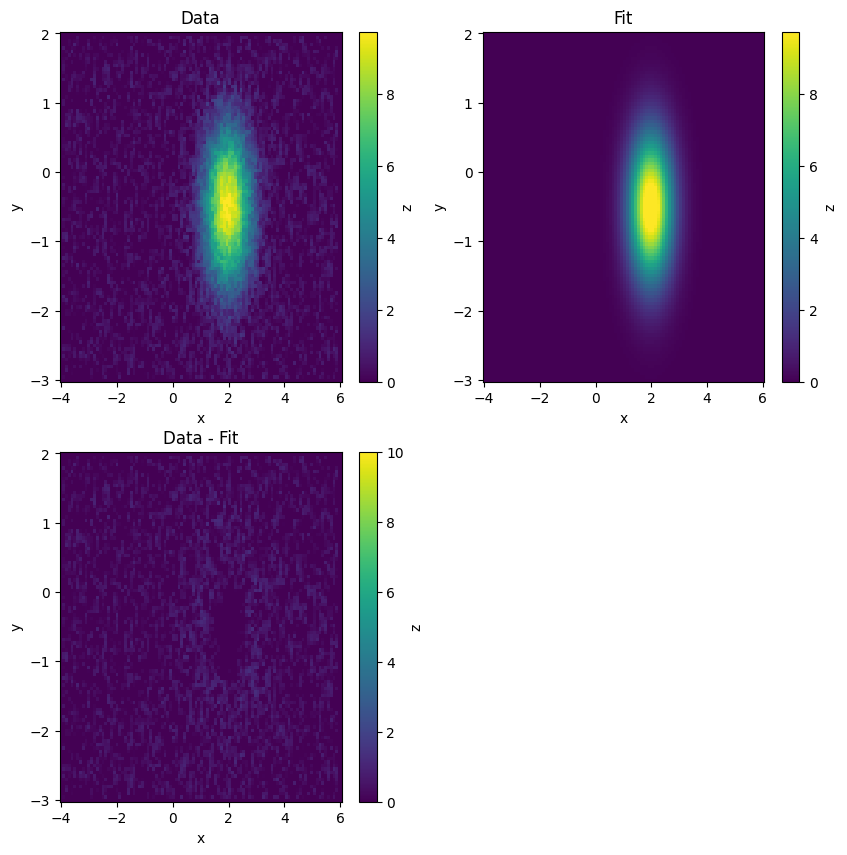

In [647]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

vmax = np.nanpercentile(Z, 99.9)

ax = axs[0, 0]
art = ax.pcolor(X, Y, Z, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data')

ax = axs[0, 1]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, fit, vmin=0, vmax=vmax, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Fit')

ax = axs[1, 0]
fit = model.func(X, Y, **result.best_values)
art = ax.pcolor(X, Y, Z-fit, vmin=0, vmax=10, shading='auto')
plt.colorbar(art, ax=ax, label='z')
ax.set_title('Data - Fit')

for ax in axs.ravel():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
axs[1, 1].remove()
plt.show()

## now try to aplly the LMfit to our dataset ##


## put it all into a function ##

In [648]:
def fit_gauss2d_to_point(reflex):
       
    X , Y = np.meshgrid(range(int(-np.floor(reflex.shape[0]/2)), int(+np.floor(reflex.shape[0]/2))), 
                    range(int(-np.floor(reflex.shape[1]/2)), int(+np.floor(reflex.shape[1]/2))))
    x=X.flatten()
    y=Y.flatten()
    z=reflex.flatten()
    print([x.shape,z.shape])
    model = lmfit.models.Gaussian2dModel()
    params = model.guess(z, x, y)
    # params.set(centerx={'value':0,'min':-5,'max':5})
    # params.set(centery={'value':0,'min':-5,'max':5})
    # params.set(sigmax={'value':0.2,'min':-2,'max':2})
    # params.set(sigmay={'value':0.2,'min':-2,'max':2})
    result = model.fit(z, x=x, y=y, params=params)
    return result

In [649]:
# def fit_all_gaussians(img_new):
# coordinates = peak_local_max(img_new, min_distance=20,threshold_abs=0.05*np.max(img_new))
results=[]
fits=[]
amplitudes=[]
chisqr=[]
for i in range(coordinates.shape[0]):
    crop=10
    reflex=img_new[coordinates[i,0]-crop:coordinates[i,0]+crop,coordinates[i,1]-crop:coordinates[i,1]+crop]
    if reflex.shape[0]==reflex.shape[1] | reflex.shape[0] % 2 !=0 | reflex.shape[1] % 2 !=1 :
        result=fit_gauss2d_to_point(reflex)
        print(result)
        if hasattr(result,'uvars'):
            temp=result.uvars['amplitude']
        else:
            continue
        # if temp.s/temp.n<0.4:
        result.params['centerx'].value=result.params['centerx'].value+coordinates[i,1]
        result.params['centery'].value=result.params['centerx'].value+coordinates[i,0]
        result.best_values['centerx']=result.best_values['centerx']+coordinates[i,1]+0
        result.best_values['centery']=result.best_values['centery']+coordinates[i,0]+0
        results.append(result)
        X, Y =  np.meshgrid(range(0,img_new.shape[1]),range(0,img_new.shape[0]))
        amplitudes.append(result.best_values['amplitude'])
        fit = model.func(X, Y, **result.best_values)
        fits.append(fit)
        # print(result.)
        chisqr.append(result.chisqr)



[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]
[(400,), (400,)]


Text(0.5, 1.0, 'differences')

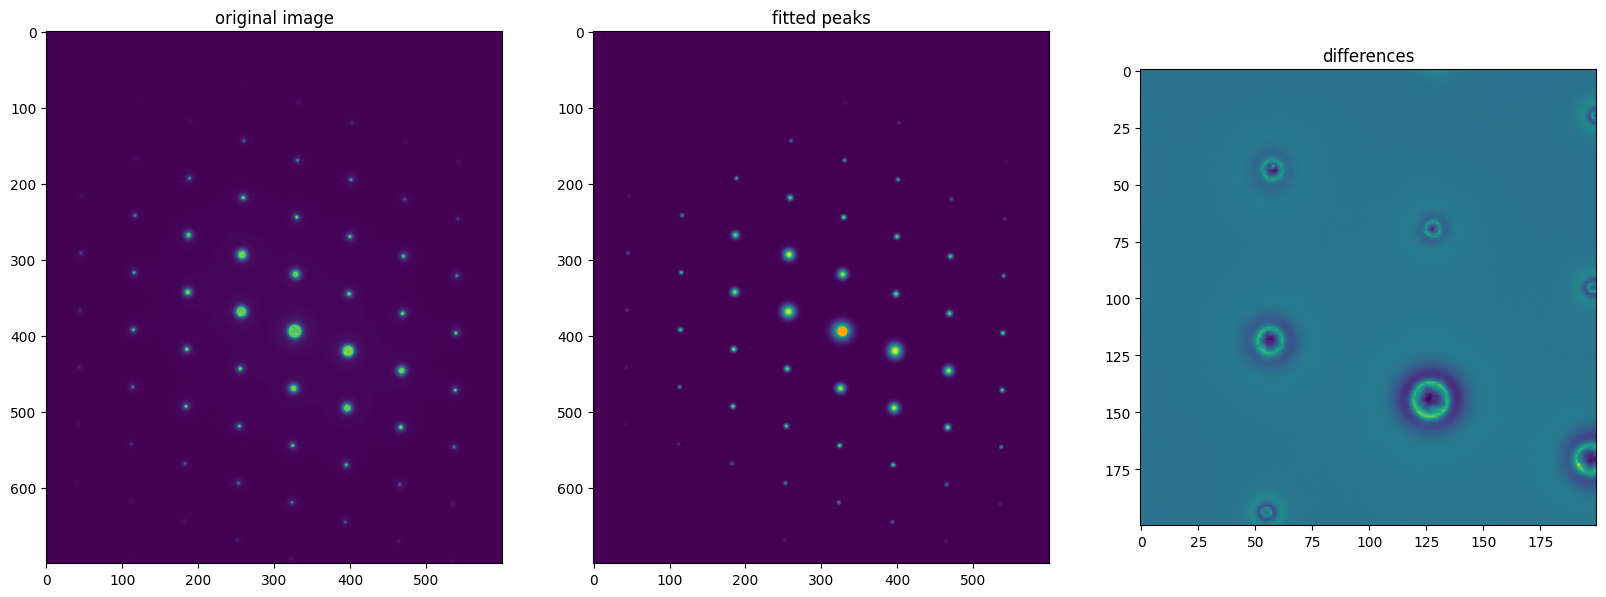

In [654]:
fig,ax=plt.subplots(1,3,figsize=(20,15))
img_fitted=np.sum(np.array(fits),axis=0)
ax[0].imshow(img_new)
ax[0].set_title('original image')

ax[1].imshow(np.sum(np.array(fits),axis=0))
ax[1].set_title('fitted peaks')

diff_img=img_new-img_fitted
primary=results[np.argmax(amplitudes)]
ax[1].scatter(primary.best_values['centerx'],primary.best_values['centery'],color='orange')
ax[2].imshow(diff_img[250:450,200:400])

ax[2].set_title('differences')

# fig.colorbar(img_new-img_fitted)

In [655]:
primary.best_values['centerx'],primary.best_values['centery']

(327.0408743897654, 394.14432732737123)

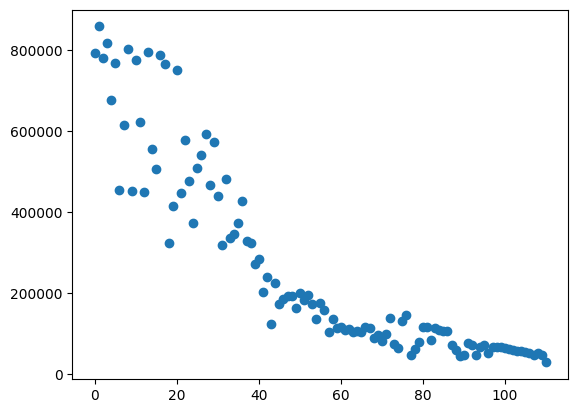

In [630]:
plt.scatter(range(0,len(amplitudes)),amplitudes)

## now that we have done all that, we can extract the distances (our primary purpose)##

In [631]:
sorted_intensities=np.flip(np.argsort(amplitudes))

In [632]:
distances=np.zeros(len(results))
primary_x=results[sorted_intensities[0]].best_values['centerx']
primary_y=results[sorted_intensities[0]].best_values['centery']
distances[sorted_intensities[0]]=0
for index in sorted_intensities[1:]:
    current_x=results[index].best_values['centerx']
    current_y=results[index].best_values['centery']
    distances[index]=np.sqrt((primary_x-current_x)**2+(primary_y-current_y)**2)


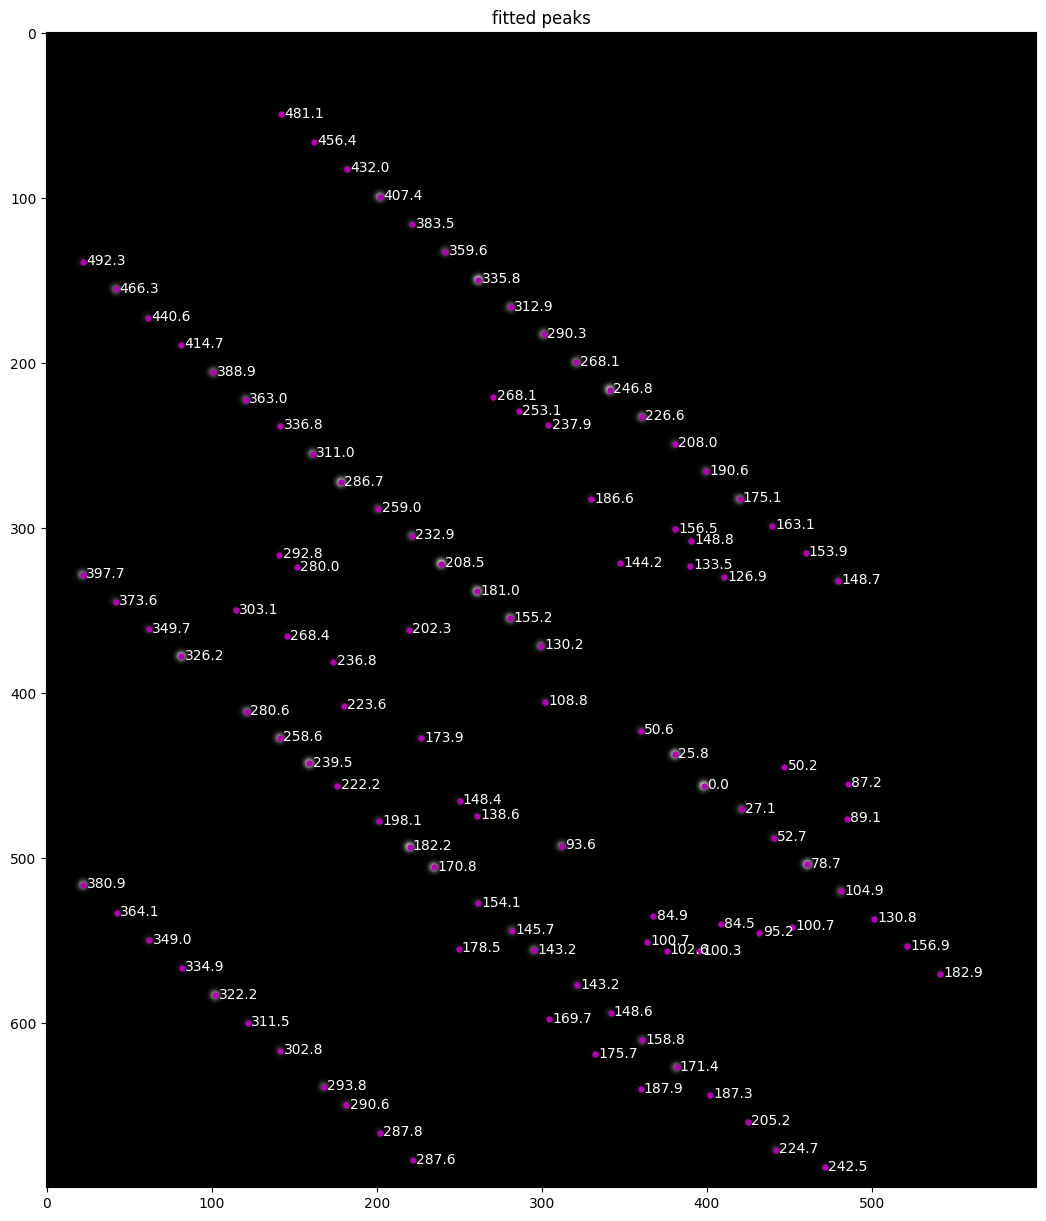

In [633]:
fig,ax=plt.subplots(1,1,figsize=(20,15))

ax.imshow(np.sum(np.array(fits),axis=0),cmap='gray')
ax.set_title('fitted peaks')

diff_img=img_new-img_fitted
primary=results[np.argmax(amplitudes)]
for index in sorted_intensities[0:]:
    ax.scatter(results[index].best_values['centerx'],results[index].best_values['centery'],color=[0.7,0,0.7],marker='.',s=50)
    ax.annotate(f'{distances[index]:.1f}',(results[index].best_values['centerx']+2,results[index].best_values['centery']+2),color='white')

In [ ]:
figure
